In [25]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
! pip install chart_studio

In [27]:
import tensorflow
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
tensorflow.random.set_seed(1)
seed(1)

In [28]:
#Loading data
train = pd.read_csv('/content/gdrive/My Drive/datasets/sales/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/gdrive/My Drive/datasets/sales/test.csv', parse_dates=['date'])

In [29]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [30]:
#Train set
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [31]:
#Time period of the train dataset
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


finding out what's the time gap between the last day from training set from the last day of the test set, this will be out lag (the amount of day that need to be forecast)

In [32]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size) # Number of days we want to predict into the future

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


**Basic EDA**
To explore the time series data first we need to aggregate the sales by day

In [33]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()

In [34]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

**Overall daily sales**

In [35]:
configure_plotly_browser_state()
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

**Daily sales by store**

In [36]:
configure_plotly_browser_state()
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

**Daily sales by item**

In [37]:
configure_plotly_browser_state()
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

layout = go.Layout(title='Item daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=item_daily_sales_sc, layout=layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
#Sub-sample train set to get only the last year of data and reduce training time
train = train[(train['date'] >= '2017-01-01')]

In [39]:
#Rearrange dataset so we can apply shift methods
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19
1,1,1,2017-01-02,15
2,1,1,2017-01-03,10
3,1,1,2017-01-04,16
4,1,1,2017-01-05,14


**Transform the data into a time series problem**

In [40]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
#We are using the current timestep and the last 29 to forecast 90 days ahead
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series.head()

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),store(t-26),sales(t-26),item(t-25),store(t-25),sales(t-25),item(t-24),store(t-24),sales(t-24),item(t-23),store(t-23),sales(t-23),item(t-22),store(t-22),sales(t-22),item(t-21),store(t-21),sales(t-21),item(t-20),store(t-20),sales(t-20),item(t-19),store(t-19),sales(t-19),item(t-18),store(t-18),sales(t-18),item(t-17),store(t-17),sales(t-17),item(t-16),...,sales(t-12),item(t-11),store(t-11),sales(t-11),item(t-10),store(t-10),sales(t-10),item(t-9),store(t-9),sales(t-9),item(t-8),store(t-8),sales(t-8),item(t-7),store(t-7),sales(t-7),item(t-6),store(t-6),sales(t-6),item(t-5),store(t-5),sales(t-5),item(t-4),store(t-4),sales(t-4),item(t-3),store(t-3),sales(t-3),item(t-2),store(t-2),sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,...,10.0,1.0,1.0,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1,1,9,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,...,16.0,1.0,1.0,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1,1,17,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,...,22.0,1.0,1.0,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1,1,15,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,...,13.0,1.0,1.0,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1,1,17,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,1.0,20.0,1.0,1.0,18.0,1.0,1.0,11.0,1.0,1.0,14.0,1.0,1.0,17.0,1.0,1.0,7.0,1.0,1.0,16.0,1.0,1.0,29.0,1.0,1.0,15.0,1.0,1.0,14.0,1.0,...,21.0,1.0,1.0,9.0,1.0,1.0,18.0,1.0,1.0,14.0,1.0,1.0,13.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,24.0,1.0,1.0,9.0,1.0,1.0,17.0,1.0,1.0,15.0,1.0,1.0,17.0,1,1,24,1.0,1.0,19.0


In [42]:
#Drop rows with different item or store values than the shifted columns
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

In [43]:
#Remove unwanted columns
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

**Train/validation split**

In [44]:
# Label
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,121.0,136.0,82.0,106.0,81.0,80.0,108.0,131.0,115.0,86.0,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,37.0,36.0,48.0,35.0,42.0,40.0,43.0,54.0,56.0,64.0,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,55.0,64.0,30.0,38.0,36.0,38.0,38.0,40.0,46.0,43.0,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,112.0,110.0,104.0,115.0,143.0,156.0,95.0,88.0,106.0,128.0,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,78.0,95.0,100.0,63.0,77.0,80.0,103.0,64.0,71.0,74.0,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62


**MLP for Time Series Forecasting**
First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.
The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.
Input shape [samples, timesteps].

In [45]:
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [46]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 3,201
Trainable params: 3,201
Non-trainable params: 0
_________________________________________________________________


In [47]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 4s - loss: 396.4911 - val_loss: 371.0771
Epoch 2/40
3149/3149 - 4s - loss: 363.5623 - val_loss: 364.3548
Epoch 3/40
3149/3149 - 4s - loss: 357.8807 - val_loss: 374.3033
Epoch 4/40
3149/3149 - 4s - loss: 356.4060 - val_loss: 384.1916
Epoch 5/40
3149/3149 - 4s - loss: 355.2372 - val_loss: 356.0964
Epoch 6/40
3149/3149 - 4s - loss: 353.8822 - val_loss: 351.6781
Epoch 7/40
3149/3149 - 4s - loss: 352.5963 - val_loss: 357.0752
Epoch 8/40
3149/3149 - 4s - loss: 351.3348 - val_loss: 349.6163
Epoch 9/40
3149/3149 - 4s - loss: 350.8070 - val_loss: 354.4187
Epoch 10/40
3149/3149 - 4s - loss: 349.4966 - val_loss: 350.2366
Epoch 11/40
3149/3149 - 4s - loss: 348.6501 - val_loss: 347.5538
Epoch 12/40
3149/3149 - 4s - loss: 347.2448 - val_loss: 346.4115
Epoch 13/40
3149/3149 - 4s - loss: 348.3179 - val_loss: 348.0815
Epoch 14/40
3149/3149 - 4s - loss: 346.5551 - val_loss: 347.3356
Epoch 15/40
3149/3149 - 4s - loss: 345.8142 - val_loss: 344.8464
Epoch 16/40
3149/3149 - 4s - loss:

**NN for Time Series Forecasting**
For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
The convolutional layer should be able to identify patterns between the timesteps.
Input shape [samples, timesteps, features].
Data preprocess
Reshape from [samples, timesteps] into [samples, timesteps, features].
This same reshaped data will be used on the CNN and the LSTM model.

In [48]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [49]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 64)            192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                44850     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 45,093
Trainable params: 45,093
Non-trainable params: 0
_________________________________________________________________


In [50]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 8s - loss: 415.7041 - val_loss: 387.3647
Epoch 2/40
3149/3149 - 8s - loss: 384.4199 - val_loss: 380.6848
Epoch 3/40
3149/3149 - 8s - loss: 373.1571 - val_loss: 373.9488
Epoch 4/40
3149/3149 - 8s - loss: 368.4057 - val_loss: 384.7602
Epoch 5/40
3149/3149 - 8s - loss: 366.8923 - val_loss: 365.1772
Epoch 6/40
3149/3149 - 8s - loss: 364.8564 - val_loss: 361.7822
Epoch 7/40
3149/3149 - 8s - loss: 363.0933 - val_loss: 368.0952
Epoch 8/40
3149/3149 - 8s - loss: 361.4189 - val_loss: 356.9911
Epoch 9/40
3149/3149 - 8s - loss: 360.2968 - val_loss: 362.5386
Epoch 10/40
3149/3149 - 8s - loss: 358.5903 - val_loss: 354.3148
Epoch 11/40
3149/3149 - 8s - loss: 357.2388 - val_loss: 354.2019
Epoch 12/40
3149/3149 - 8s - loss: 355.9755 - val_loss: 352.5007
Epoch 13/40
3149/3149 - 8s - loss: 356.5324 - val_loss: 351.3797
Epoch 14/40
3149/3149 - 8s - loss: 354.2564 - val_loss: 352.3125
Epoch 15/40
3149/3149 - 8s - loss: 353.2155 - val_loss: 349.2675
Epoch 16/40
3149/3149 - 8s - loss:

**LSTM for Time Series Forecasting**
Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
Input shape [samples, timesteps, features].

In [51]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [52]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/40
3149/3149 - 37s - loss: 524.9683 - val_loss: 398.8583
Epoch 2/40
3149/3149 - 39s - loss: 388.0672 - val_loss: 383.8524
Epoch 3/40
3149/3149 - 39s - loss: 456.0257 - val_loss: 397.9056
Epoch 4/40
3149/3149 - 39s - loss: 382.9272 - val_loss: 398.1927
Epoch 5/40
3149/3149 - 39s - loss: 394.6127 - val_loss: 372.7812
Epoch 6/40
3149/3149 - 39s - loss: 373.4935 - val_loss: 367.2171
Epoch 7/40
3149/3149 - 40s - loss: 384.9585 - val_loss: 376.3337
Epoch 8/40
3149/3149 - 40s - loss: 365.5742 - val_loss: 355.3962
Epoch 9/40
3149/3149 - 40s - loss: 377.0750 - val_loss: 376.1758
Epoch 10/40
3149/3149 - 40s - loss: 371.3468 - val_loss: 398.4141
Epoch 11/40
3149/3149 - 40s - loss: 368.8279 - val_loss: 355.8431
Epoch 12/40
3149/3149 - 40s - loss: 357.6443 - val_loss: 353.2440
Epoch 13/40
3149/3149 - 39s - loss: 355.6709 - val_loss: 353.7796
Epoch 14/40
3149/3149 - 39s - loss: 352.1805 - val_loss: 349.2639
Epoch 15/40
3149/3149 - 39s - loss: 348.3095 - val_loss: 346.7236
Epoch 16/40
3149/31

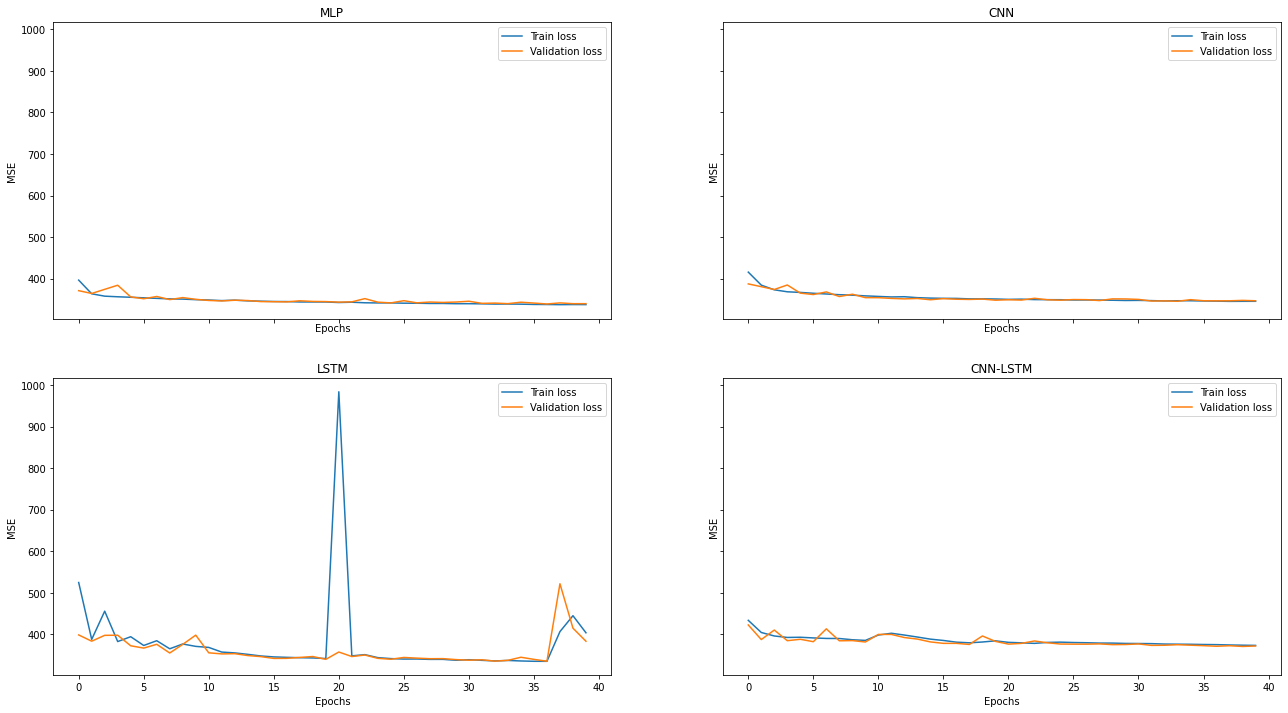

In [63]:
#Comparing models
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')



plt.show()

MLP on train and validation

In [59]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

Train rmse: 18.310913384104627
Validation rmse: 18.434630782425874


CNN on train and validation

In [60]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

Train rmse: 18.521587446283068
Validation rmse: 18.62250341148781


LSTM on train and validation

In [61]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

Train rmse: 19.596434140801474
Validation rmse: 18.62250341148781
